In [1]:
import numpy as np
import pandas as pd
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import matplotlib.pyplot as plt
from astropy.table import Column, join, Table, vstack, hstack
from astropy.io import ascii
from HMXB_pipeline_class import pipeline
import astropy.coordinates as coords
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import astropy_mpl_style
import corner
from datetime import datetime
import os

from Galactic_traceback import GalacticTraceback

In [2]:
today = datetime.now().strftime("%Y%m%d")

In [3]:
help(GalacticTraceback)

Help on class GalacticTraceback in module Galactic_traceback:

class GalacticTraceback(builtins.object)
 |  GalacticTraceback(table)
 |
 |  Methods defined here:
 |
 |  __init__(self, table)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  trace_linear_path(self, time_step=1000)
 |      Trace the path of the star in Galactic coordinates until b = 0, using the Euler method.
 |
 |      Parameters:
 |      - time_step (float): Step size in years for tracing the path.
 |      - max_steps (int): Maximum number of steps for tracing.
 |
 |      Returns:
 |      - path (list of tuples): List of (l, b) pairs representing the path.
 |
 |  traceback_time(self)
 |      Calculate the traceback time for a star
 |      The time is takes to return to the galactic midplane in years
 |
 |      input:
 |      self
 |      b - galactic longitude degrees
 |      mu_b- proper motion in b mas/yr
 |
 |      Returns
 |      -------
 |      None.
 |
 |  -----------------------------

# Colors

In [4]:
    color_map = {
        "xkcd:blue": "O I-III",
        "xkcd:red": "B I-III",
        "xkcd:bright Blue": "Oe I-III",
        "xkcd:dark blue": "Oe IV-V",
        "xkcd:green": "B0e I-III",
        "xkcd:bright green": "B1e I-III",
        "xkcd:grass green": "B2e I-III",
        "xkcd:black": "OB IV-V",
        "xkcd:grey": "M,A,None",
        "xkcd:purple": "B0e IV-V",
        "xkcd:light purple": "B1e IV-V",
        "xkcd:dark purple": "B2e IV-V",
    }
    groups = [
        ("O I-III", ['xkcd:blue'], 'xkcd:blue'),
        ("B I-III", ['xkcd:red'], 'xkcd:red'),
        ("Oe", ['xkcd:bright Blue', 'xkcd:dark blue'], 'xkcd:cobalt'),
        ("Be I-III", ['xkcd:green', 'xkcd:bright green', 'xkcd:dark green'], 'xkcd:green')
    ]
    marker_map = {
        "xkcd:blue": 'o',   # Circle marker for "O I-III"
        "xkcd:red":'o',    # Circle marker for "B I-III"
        "xkcd:bright Blue": '^',  # Triangle marker for "Oe I-III"
        "xkcd:dark blue":'^',  # Triangle marker for "Oe IV-V"
        "xkcd:green": '^',  # Circle marker for "B0e I-III"
        "xkcd:bright green": '^',  # Circle marker for "B1e I-III"
        "xkcd:grass green":'^',  # Circle marker for "B2e I-III"
        "xkcd:black": 'x',   # Cross marker for "OB IV-V"
        "xkcd:grey": 'x',  # Cross marker for "M,A,None"
        "xkcd:purple": '^',  # Circle marker for "B0e IV-V"
        "xkcd:light purple": '^',  # Circle marker for "B1e IV-V"
        "xkcd:dark purple": '^'  # Circle marker for "B2e IV-V"
    }

# DNE This file

In [5]:
HMXB_read = ascii.read('HMXB_practice_analysis.ecsv',format='ecsv')

In [6]:
HMXB_trace = HMXB_read

In [7]:
HMXB_trace

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,mag,mag,mag,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,mas / yr,mas / yr,km / s,mas / yr,mas / yr,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,nan,nan,6.261697,163.0813533466715,-17.136203125538678,6.4398537,5.93006,0.50979376,0.6144760897364175,0.3095889769659371,-2.245323934218814,9.063394189676286,223.81506681128036,57.77572175230654,5.54632682187915,-1.8486200400580908,-0.4202484622115612,-0.4025983375739546,14.02859774983416,-4.8164893827016515,0.0058944434132315315,B0Ve,xkcd:purple,xkcd:green
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,nan,nan,7.231733,170.05338802722687,0.7103172589013076,7.376429,6.921238,0.45519114,1.3862516284046154,4.038422032220199,-1.1789249333274139,9.868215163177801,224.56128708057972,33.03724050675546,2.322547203858686,-1.1721755380409382,-0.1306188566067849,0.009940439865081115,12.133496727382866,1.8464936849682976,-0.01668983515155678,B0 IVpe,xkcd:purple,xkcd:green
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,nan,nan,10.403856,159.8470955000755,-1.2700235829277626,10.832097,9.790907,1.0411901,2.639752590095405,0.9593255549561471,-0.7047859211231655,11.015119773159219,225.5294017486117,59.20502188807201,1.3177498233849931,-0.597587187998077,-0.4438073449784902,-0.030656812265844154,1.434785114595448,0.08538307654964422,-0.07654192085924438,B0e,xkcd:green,xkcd:green
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,nan,nan,10.766115,149.17651611413766,4.133059262254314,11.439369,9.855047,1.584322,4.759904563202022,0.02670675915560328,-0.6952017931699837,12.810032757999913,226.8654620531654,75.83556855602039,0.7629157021820535,-0.3433404950633777,-0.7985036619761263,0.12115839202699431,10.764396229063566,0.06229471894967609,-0.47301969013360023,B1/2I[e],xkcd:green,xkcd:green
414196617287885312,18.996040698840275,0.010982572,59.15394486765568,0.012779636,-2.4625832668630094,0.014893881,-0.546486466252775,0.016773285,0.3391933399322079,0.01803902,nan,nan,11.412056,126.08000772759438,-3.5676859152271287,11.667166,10.951165,0.71600056,2.9481710938070385,-2.3920245855272095,-0.800738525527853,10.505550935625854,225.1118353299879,145.18545631063174,1.197749379234627,-0.5634229362770962,-2.644620505556004,-0.1511493220972492,13.262661170839669,-0.9451534592058328,-0.08616626715350759,B1-2 III/Ve,xkcd:green,xkcd:green
426558460884582016,14.177450998208093,1.8335997,60.71672280471204,2.3911946,nan,nan,nan,nan,nan,nan,nan,nan,2.0645833,123.57698659515256,-2.1484240190698634,2.7258432,2.3151085,0.41073465,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,B0.5IVpe,xkcd:purple,xkcd:green
427234969757165952,9.290132580203235,0.008413794,61.36013319063004,0.009818237,-1.7956235405295953,0.010947091,-0.5251300483100196,0.013608978,0.27189066538368456,0.012059882,nan

In [8]:
#make a sample
HMXB_sample = HMXB_trace[6:16]
HMXB_sample

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,mag,mag,mag,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,mas / yr,mas / yr,km / s,mas / yr,mas / yr,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
427234969757165952,9.290132580203235,0.008413794,61.36013319063004,0.009818237,-1.7956235405295953,0.010947091,-0.5251300483100196,0.013608978,0.27189066538368456,0.012059882,nan,nan,9.454656,121.22141620023214,-1.4641898756122689,9.768971,8.949126,0.8198452,3.677948996847052,-1.8178140519374264,-0.4422414945716403,10.870491734584071,225.41280416340064,148.84601654902679,0.934142743735759,-0.4446418257894607,-2.8427897106767976,-0.06013234426507411,1.922506718205155,0.09083291500361224,0.06253267548289451,BN0.5II-III / BN0.7Ib,xkcd:red,xkcd:red
444752973131169664,53.749629724978455,0.013929484,53.17313997828423,0.012730369,-0.26805266659388,0.019742586,0.4401283844933388,0.019827945,0.13434727271763658,0.020151323,nan,nan,14.200214,146.05208942276994,-2.1940257086354467,15.475269,13.086571,2.3886986,7.4433963546230135,-0.4757472370713855,0.19806512394601175,15.246797070152677,228.41658713708378,69.86204140982059,0.490706563956873,-0.21377081081802612,-0.7535385861904507,-0.05899033651392215,18.231124932309566,-0.21291521483780784,0.47082627127796006,O8-9Ve,xkcd:dark blue,xkcd:blue
465628193526364416,40.91843191991435,0.0067567313,61.434377668355616,0.008564885,-0.7289798897496916,0.010312551,0.13432816094165279,0.011728739,0.18150880543038156,0.011328216,nan,nan,12.386541,135.93415668064728,1.4287879422071408,13.053085,11.576575,1.47651,5.509374587248629,-0.7167206082424593,-0.18912245821688806,13.033092972257004,227.01875464430518,101.44777357619816,0.6618328532770354,-0.28931468482332157,-1.4551194295251804,0.05081322952339959,2.379228998306617,0.0765659680056856,0.04937899708303392,O9.5Ve,xkcd:dark blue,xkcd:blue
465645515129855872,40.131931264833995,0.007332206,61.22933050838676,0.009209115,-0.42343174759612834,0.011322314,-0.2555250178055092,0.011918911,0.37764990611808313,0.012974979,nan,nan,10.402225,135.6752737697255,1.0861251738760371,10.956625,9.673551,1.2830744,2.647955113451878,-0.279058609498088,-0.4083059784791434,10.55731349418469,225.15512988222542,125.14148357300378,1.3763937827588224,-0.6027230250842298,-1.9523294515554024,0.045239492513842156,4.1701693455948226,0.29687705929849195,0.14917755409124425,B0Ve,xkcd:purple,xkcd:green
511220031584305536,26.750875487648646,0.011500537,61.356572911514526,0.013774355,-1.029427556881088,0.01621835,-0.08166309914192828,0.016919507,0.32796283875254345,0.021653285,nan,nan,11.215371,129.54110404226162,-0.8001119868579849,11.629826,10.599628,1.0301971,3.0491259430600497,-0.9855121261320304,-0.30847334710531277,10.702430954822386,225.27542868600665,136.3058652913444,1.175325068529664,-0.5292864333891744,-2.3422924600071307,-0.033732762415593746,4.5179825629905,0.18145526534543643,0.25454584869945535,B1III-Ve,xkcd:green,xkcd:green
518990967445248256,29.577032913394262,0.008842416,67.22318460660581,0.010229338,-1.1979575137021086,0.010899313,0.3002206665717444,0.013282542,0.1332721013963377,0.013151252,nan,nan,13.687518,129.3522357669255,5.1887233924182254,14.563635,12.747923,1.815712,7.503445878939821,-1.2346680901134437,-0.02879862024023381,14.44447656647617,227.9339422036374,101.6395225379512,0.4772717290571347,-0.20348214593197522

In [9]:
HMXB_sample = GalacticTraceback(HMXB_sample).traceback_time()

In [10]:
HMXB_sample

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,SpType,Mod_SpType,SpColor,Trace Time
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,mag,mag,mag,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,mas / yr,mas / yr,km / s,mas / yr,mas / yr,,,,Million years
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,float64
427234969757165952,9.290132580203235,0.008413794,61.36013319063004,0.009818237,-1.7956235405295953,0.010947091,-0.5251300483100196,0.013608978,0.27189066538368456,0.012059882,nan,nan,9.454656,121.22141620023214,-1.4641898756122689,9.768971,8.949126,0.8198452,3.677948996847052,-1.8178140519374264,-0.4422414945716403,10.870491734584071,225.41280416340064,148.84601654902679,0.934142743735759,-0.4446418257894607,-2.8427897106767976,-0.06013234426507411,1.922506718205155,0.09083291500361224,0.06253267548289451,BN0.5II-III / BN0.7Ib,xkcd:red,xkcd:red,11.919016231866244
444752973131169664,53.749629724978455,0.013929484,53.17313997828423,0.012730369,-0.26805266659388,0.019742586,0.4401283844933388,0.019827945,0.13434727271763658,0.020151323,nan,nan,14.200214,146.05208942276994,-2.1940257086354467,15.475269,13.086571,2.3886986,7.4433963546230135,-0.4757472370713855,0.19806512394601175,15.246797070152677,228.41658713708378,69.86204140982059,0.490706563956873,-0.21377081081802612,-0.7535385861904507,-0.05899033651392215,18.231124932309566,-0.21291521483780784,0.47082627127796006,O8-9Ve,xkcd:dark blue,xkcd:blue,39.87826020920556
465628193526364416,40.91843191991435,0.0067567313,61.434377668355616,0.008564885,-0.7289798897496916,0.010312551,0.13432816094165279,0.011728739,0.18150880543038156,0.011328216,nan,nan,12.386541,135.93415668064728,1.4287879422071408,13.053085,11.576575,1.47651,5.509374587248629,-0.7167206082424593,-0.18912245821688806,13.033092972257004,227.01875464430518,101.44777357619816,0.6618328532770354,-0.28931468482332157,-1.4551194295251804,0.05081322952339959,2.379228998306617,0.0765659680056856,0.04937899708303392,O9.5Ve,xkcd:dark blue,xkcd:blue,27.197386499951893
465645515129855872,40.131931264833995,0.007332206,61.22933050838676,0.009209115,-0.42343174759612834,0.011322314,-0.2555250178055092,0.011918911,0.37764990611808313,0.012974979,nan,nan,10.402225,135.6752737697255,1.0861251738760371,10.956625,9.673551,1.2830744,2.647955113451878,-0.279058609498088,-0.4083059784791434,10.55731349418469,225.15512988222542,125.14148357300378,1.3763937827588224,-0.6027230250842298,-1.9523294515554024,0.045239492513842156,4.1701693455948226,0.29687705929849195,0.14917755409124425,B0Ve,xkcd:purple,xkcd:green,9.576275714888808
511220031584305536,26.750875487648646,0.011500537,61.356572911514526,0.013774355,-1.029427556881088,0.01621835,-0.08166309914192828,0.016919507,0.32796283875254345,0.021653285,nan,nan,11.215371,129.54110404226162,-0.8001119868579849,11.629826,10.599628,1.0301971,3.0491259430600497,-0.9855121261320304,-0.30847334710531277,10.702430954822386,225.27542868600665,136.3058652913444,1.175325068529664,-0.5292864333891744,-2.3422924600071307,-0.033732762415593746,4.5179825629905,0.18145526534543643,0.25454584869945535,B1III-Ve,xkcd:green,xkcd:green,9.337607866994668
518990967445248256,29.577032913394262,0.008842416,67.22318460660581,0.010229338,-1.1979575137021086,0.010899313,0.3002206665717444,0.013282542,0.1332721013963377,0.013151252,nan,nan,13.687518,129.3522357669255,5.1887233924182254,14.563635,12.747923,1.815712,7.503445878939821,-1.234668

In [11]:
HMXB_trace = GalacticTraceback(HMXB_trace).traceback_time()

In [12]:
HMXB_sample = GalacticTraceback(HMXB_sample).trace_linear_path()

In [13]:
HMXB_sample

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,SpType,Mod_SpType,SpColor,Trace Time,Galactic Path
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,mag,mag,mag,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,mas / yr,mas / yr,km / s,mas / yr,mas / yr,,,,Million years,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,float64,"float64[1000001,2]"
427234969757165952,9.290132580203235,0.008413794,61.36013319063004,0.009818237,-1.7956235405295953,0.010947091,-0.5251300483100196,0.013608978,0.27189066538368456,0.012059882,nan,nan,9.454656,121.22141620023214,-1.4641898756122689,9.768971,8.949126,0.8198452,3.677948996847052,-1.8178140519374264,-0.4422414945716403,10.870491734584071,225.41280416340064,148.84601654902679,0.934142743735759,-0.4446418257894607,-2.8427897106767976,-0.06013234426507411,1.922506718205155,0.09083291500361224,0.06253267548289451,BN0.5II-III / BN0.7Ib,xkcd:red,xkcd:red,11.919016231866244,121.22141620023214 .. 31.38066972808704
444752973131169664,53.749629724978455,0.013929484,53.17313997828423,0.012730369,-0.26805266659388,0.019742586,0.4401283844933388,0.019827945,0.13434727271763658,0.020151323,nan,nan,14.200214,146.05208942276994,-2.1940257086354467,15.475269,13.086571,2.3886986,7.4433963546230135,-0.4757472370713855,0.19806512394601175,15.246797070152677,228.41658713708378,69.86204140982059,0.490706563956873,-0.21377081081802612,-0.7535385861904507,-0.05899033651392215,18.231124932309566,-0.21291521483780784,0.47082627127796006,O8-9Ve,xkcd:dark blue,xkcd:blue,39.87826020920556,146.05208942276994 .. 32.78788430657074
465628193526364416,40.91843191991435,0.0067567313,61.434377668355616,0.008564885,-0.7289798897496916,0.010312551,0.13432816094165279,0.011728739,0.18150880543038156,0.011328216,nan,nan,12.386541,135.93415668064728,1.4287879422071408,13.053085,11.576575,1.47651,5.509374587248629,-0.7167206082424593,-0.18912245821688806,13.033092972257004,227.01875464430518,101.44777357619816,0.6618328532770354,-0.28931468482332157,-1.4551194295251804,0.05081322952339959,2.379228998306617,0.0765659680056856,0.04937899708303392,O9.5Ve,xkcd:dark blue,xkcd:blue,27.197386499951893,135.93415668064728 .. 53.96280411272426
465645515129855872,40.131931264833995,0.007332206,61.22933050838676,0.009209115,-0.42343174759612834,0.011322314,-0.2555250178055092,0.011918911,0.37764990611808313,0.012974979,nan,nan,10.402225,135.6752737697255,1.0861251738760371,10.956625,9.673551,1.2830744,2.647955113451878,-0.279058609498088,-0.4083059784791434,10.55731349418469,225.15512988222542,125.14148357300378,1.3763937827588224,-0.6027230250842298,-1.9523294515554024,0.045239492513842156,4.1701693455948226,0.29687705929849195,0.14917755409124425,B0Ve,xkcd:purple,xkcd:green,9.576275714888808,135.6752737697255 .. 24.50445252933631
511220031584305536,26.750875487648646,0.011500537,61.356572911514526,0.013774355,-1.029427556881088,0.01621835,-0.08166309914192828,0.016919507,0.32796283875254345,0.021653285,nan,nan,11.215371,129.54110404226162,-0.8001119868579849,11.629826,10.599628,1.0301971,3.0491259430600497,-0.9855121261320304,-0.30847334710531277,10.702430954822386,225.27542868600665,136.3058652913444,1.175325068529664,-0.5292864333891744,-2.3422924600071307,-0.033732762415593746,4.5179825629905,0.18145526534543643,0.25454584869945535,B1III-Ve,xkcd:green,xkcd:green,9.337607866994668,129.54110404226162 .. 84.88692887731642
518990967445248256,29.577032913394262,0.008842416,

In [16]:

def plot_star_paths(table):
    """
    Plot the paths of stars in the Galactic coordinate system.
    
    Parameters:
    - table (Astropy Table): The table containing star data and paths.
    - path_column_name (str): Name of the column in the table storing the traced paths.
    - star_indices (list or None): Indices of the stars to plot. If None, plot all stars.
    """
    star_indices = range(len(table))
    
    plt.figure(figsize=(10, 6))
    for idx in star_indices:
        # Extract path
        path = table["Galactic Path"][idx]
        l_vals, b_vals = zip(*path)  # Unpack l and b from the path
        dist_vals = table['distance'][idx]
        z = dist_vals*np.sin(np.radians(b_vals))
        # Plot the path
        plt.scatter(l_vals, z*1000, label=f'Star {idx + 1}')
        #plt.scatter([l_vals[0]], [b_vals[0]], color='green', label=f'Start {idx + 1}' if idx == 0 else None)
        #plt.scatter([l_vals[-1]], [b_vals[-1]], color='red', label=f'End {idx + 1}' if idx == 0 else None)
    
    plt.xlabel('Galactic Longitude (l) [degrees]')
    plt.ylabel('Galactic Latitude (b) [degrees]')
    plt.title('Traced Galactic Paths of Stars')
    #plt.legend()
    plt.grid(True)
    plt.show()

    
    return None

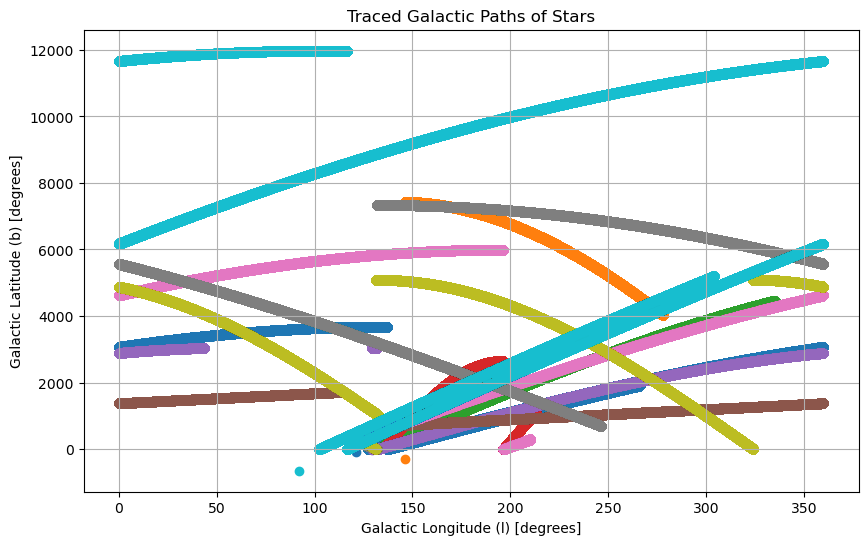

In [17]:
plot_star_paths(HMXB_sample)